# 4. Train model. Logistic regression

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
)
from fraudlib.utils import (
    load_features,
    pr_at_thresholds,
    cm_for_threshold,
    explain_confusion_matrix,
    thresholds_grid,
    save_model_thresholds,
)

In [ ]:
upstream = {
    'feature_engineering': {
        'train': 'data/interim/x_train_features_v2.parquet.gzip',
        'val': 'data/interim/x_val_features_v2.parquet.gzip',
        'test': 'data/interim/x_test_features_v2.parquet.gzip'
    }
}
product = None
VERSION = "v2"
ROOT = Path(os.path.abspath("")).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
INTERIM_DATA = os.path.join(DATA, "interim")


In [3]:
X_train = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_train_features_{VERSION}.parquet.gzip")
)
X_val = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_val_features_{VERSION}.parquet.gzip")
)
X_test = pd.read_parquet(
    os.path.join(INTERIM_DATA, f"x_test_features_{VERSION}.parquet.gzip")
)

y_train = X_train["tx_fraud"]
y_val = X_val["tx_fraud"]
y_test = X_test["tx_fraud"]

FEATURES = load_features(os.path.join(INTERIM_DATA, f"features_{VERSION}.yaml"))
FEATURES

['tx_amount',
 'sector_id',
 'tx_amount_log',
 'hour',
 'month',
 'is_month_start',
 'is_month_end',
 'is_weekend',
 'tx_amount_log_mean',
 'tx_amount_log_std',
 'tx_amount_log_deviates',
 'secs_since_prev_tx',
 'burst_id',
 'n_tx_in_burst',
 'burst_mean',
 'burst_std',
 'n_trx_per_burst_deviates',
 'hour_zscore',
 'hour_zscore_deviates',
 'rolling_median',
 'q1',
 'q3',
 'iqr',
 'amount_robust_rolling20',
 'is_amount_robust_rolling_outlier',
 'day_of_week_mean',
 'day_of_week_std',
 'is_day_of_week_mean_outlier',
 'day_of_week_zscore',
 'is_day_of_week_zscore_outlier',
 'n_tx_in_prev_24h',
 'q90_prev',
 'is_24h_burst',
 'is_24h_burst_fixed',
 'day_of_week',
 'z_in_day_robust',
 'is_anomalous_in_day',
 'fraud_burst_candidate']

## Train model

In [4]:
logit = LogisticRegression(class_weight="balanced")
logit.fit(X_train[FEATURES], y_train)
y_logit_pred_proba = logit.predict_proba(X_val[FEATURES])[:, 1]
y_logit_predict = logit.predict(X_val[FEATURES])
roc_auc = roc_auc_score(y_val, y_logit_pred_proba)
pr_auc = average_precision_score(y_val, y_logit_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

ROC AUC: 0.865
PR AUC: 0.042


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Visualization

### Precision-recall curve

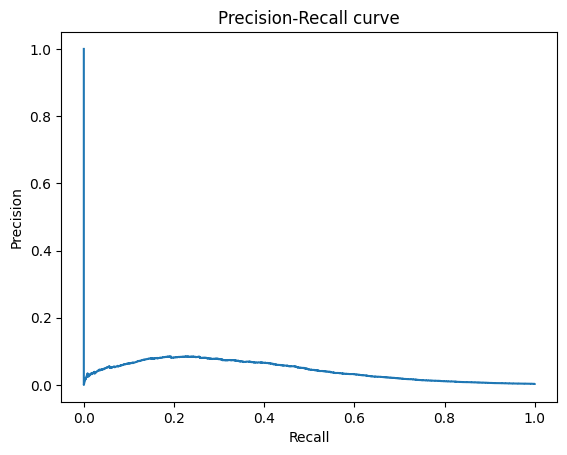

In [5]:
precision, recall, thresholds = precision_recall_curve(y_val, y_logit_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

## Threshold grid

In [6]:
grid_df = thresholds_grid(y_logit_pred_proba, y_val)
grid_df

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
0,0.000,0.003098,1.000000,0.006176,0.003869,0.015298,718,231078,0,0
1,0.001,0.003099,0.998607,0.006180,0.003871,0.015307,717,230612,1,466
2,0.002,0.003100,0.998607,0.006181,0.003872,0.015311,717,230550,1,528
3,0.003,0.003101,0.998607,0.006183,0.003873,0.015315,717,230501,1,577
4,0.004,0.003102,0.998607,0.006184,0.003874,0.015318,717,230449,1,629
...,...,...,...,...,...,...,...,...,...,...
996,0.996,0.045704,0.034819,0.039526,0.043014,0.036560,25,522,693,230556
997,0.997,0.035294,0.025070,0.029316,0.032632,0.026611,18,492,700,230586
998,0.998,0.036481,0.023677,0.028716,0.032920,0.025464,17,449,701,230629
999,0.999,0.037915,0.022284,0.028070,0.033250,0.024287,16,406,702,230672


In [7]:
max_f1 = grid_df[grid_df["f1"] == grid_df["f1"].max()]
max_f05 = grid_df[grid_df["f0.5"] == grid_df["f0.5"].max()]
max_f2 = grid_df[grid_df["f2"] == grid_df["f2"].max()]

## Precision-recall curve with marked thresholds

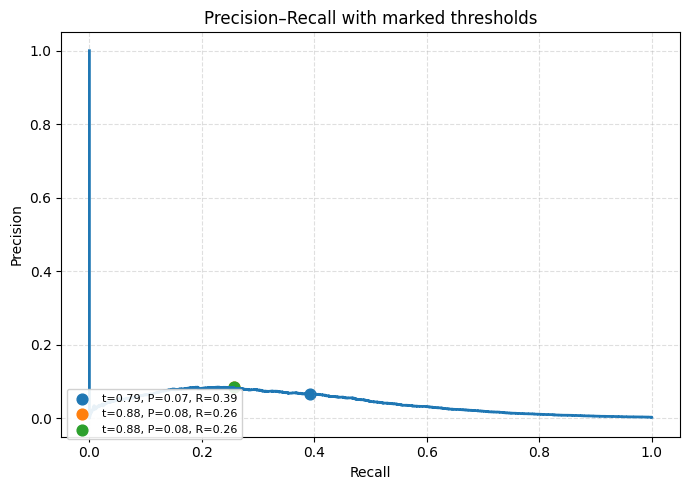

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(recall, precision, lw=2)

mark_thrs = [max_f2.thr.values[0], max_f1.thr.values[0], max_f05.thr.values[0]]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles = []
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc="lower left")

ax.legend(
    fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9
)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Confusion matrix for thresholds

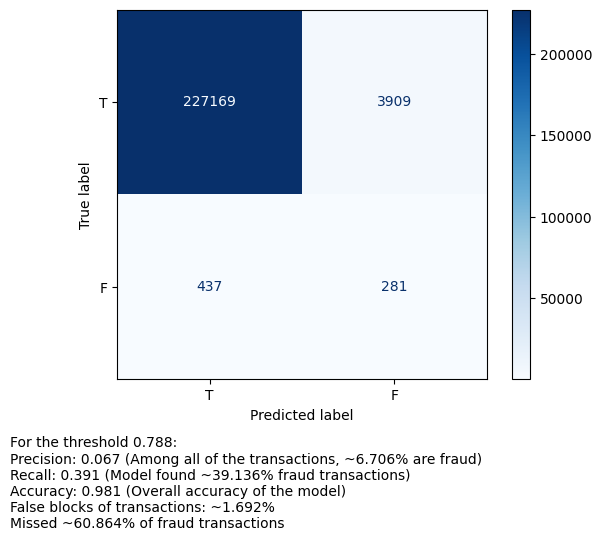

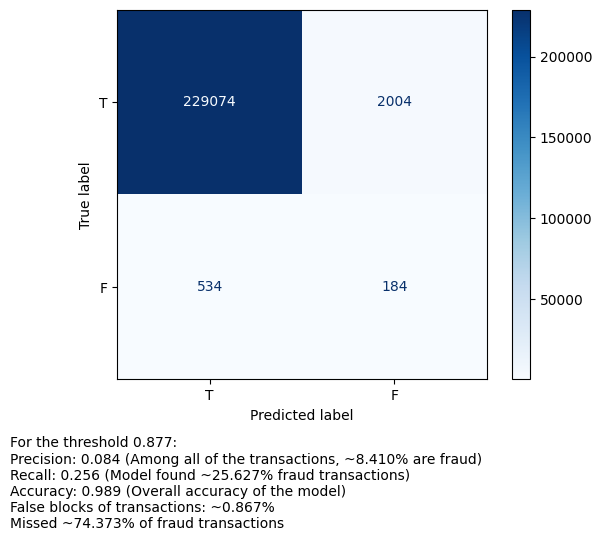

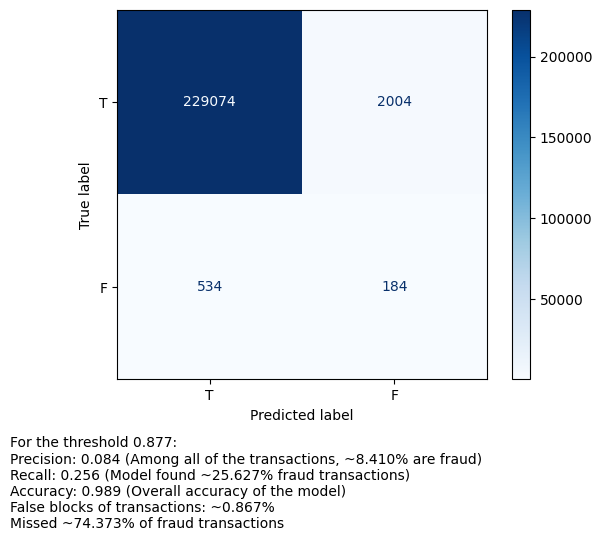

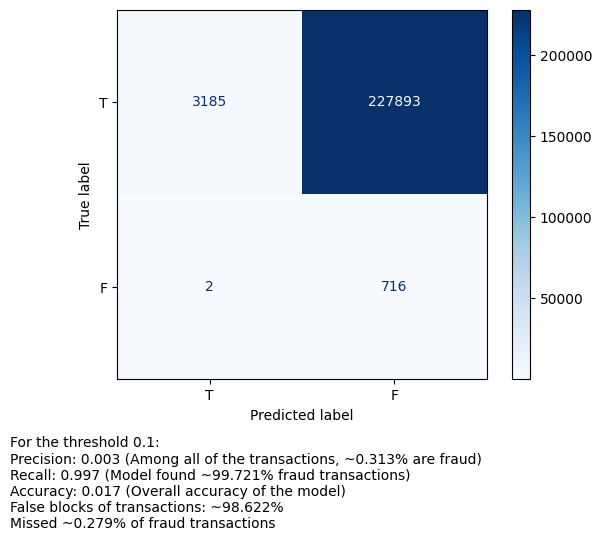

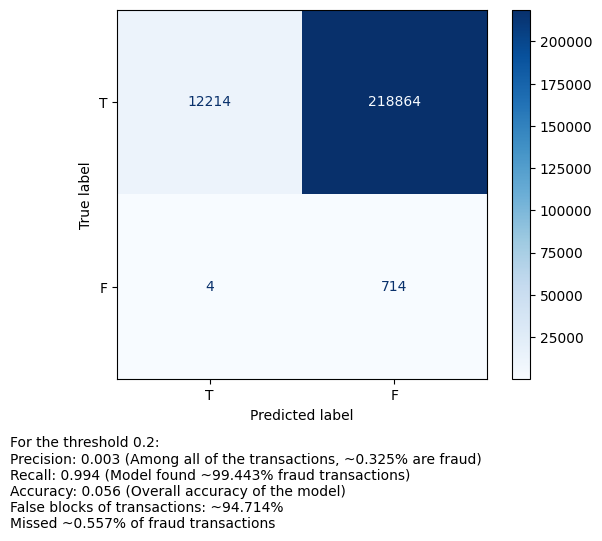

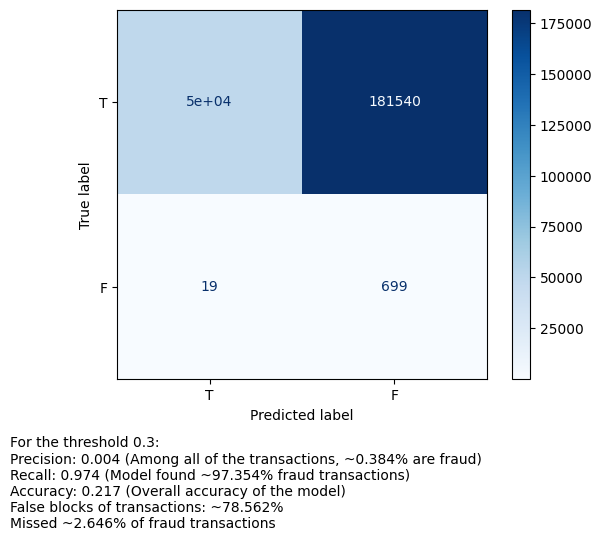

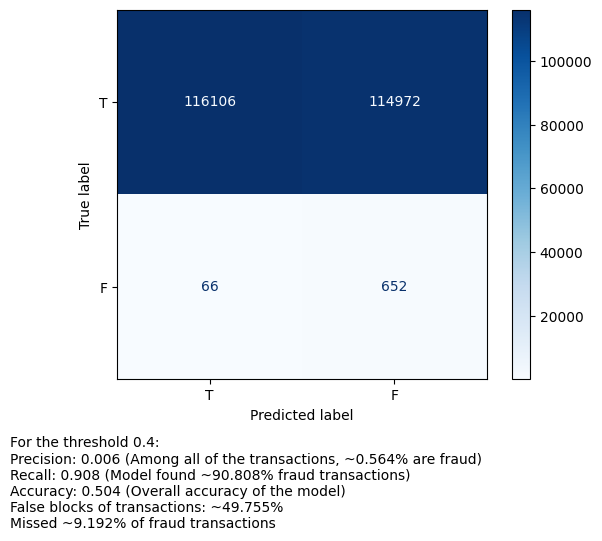

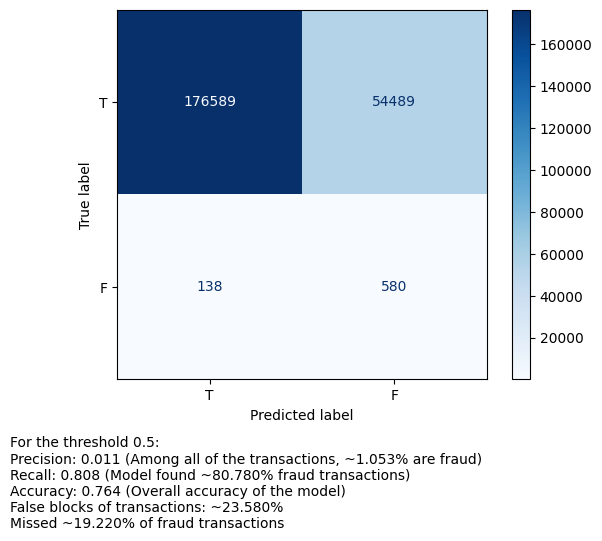

In [9]:
for thr in mark_thrs + [0.1, 0.2, 0.3, 0.4, 0.5]:
    conf_matrix = cm_for_threshold(thr, y_logit_pred_proba, y_val)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=["T", "F"]
    )
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

## Tune model

* For tuning, use [optuna](https://github.com/optuna/optuna) library

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score

def objective(trial):
    solver  = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])
    penalty = "l2" if solver != "liblinear" else trial.suggest_categorical("penalty", ["l1","l2"])
    params = {
        'tol' : trial.suggest_float('tol' , 1e-4, 1e-2, log=True),
        'C' : trial.suggest_float("C", 1e-3, 10, log=True),
       'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       'solver' : solver,
       'penalty': penalty,
        "n_jobs" : -1,
        'class_weight': 'balanced',
        'random_state': 42
    }

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            **params       
        ))
    ])

    model.fit(X_train[FEATURES], y_train)
    y_predict_proba = model.predict_proba(X_val[FEATURES])[:, 1]
    return average_precision_score(y_val, y_predict_proba)

In [ ]:
# pruner = optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=1)
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(constant_liar=True)
)
study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=4)
print("Best params:", study.best_params)
print("Best PR-AUC:", study.best_value)

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-23 08:09:08,694] A new study created in memory with name: no-name-f0b12cf7-93c2-4c5d-9dae-28b5eb5f2742


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(


[I 2025-10-23 08:09:16,915] Trial 1 finished with value: 0.08269424857769599 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'tol': 0.00011533552958919957, 'C': 0.009689010050547196, 'fit_intercept': True}. Best is trial 1 with value: 0.08269424857769599.


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(


[I 2025-10-23 08:09:28,290] Trial 3 finished with value: 0.1545987861030013 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'tol': 0.001027915301653409, 'C': 0.11446943995441637, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.
[I 2025-10-23 08:09:48,578] Trial 5 finished with value: 0.12251260421291695 and parameters: {'solver': 'saga', 'tol': 0.007041821786456675, 'C': 0.09124181446550608, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.
[I 2025-10-23 08:09:54,680] Trial 6 finished with value: 0.08717993090188411 and parameters: {'solver': 'lbfgs', 'tol': 0.0001151990048405937, 'C': 1.0819543659819135, 'fit_intercept': True}. Best is trial 3 with value: 0.1545987861030013.
[I 2025-10-23 08:09:59,621] Trial 7 finished with value: 0.14752239402162481 and parameters: {'solver': 'lbfgs', 'tol': 0.00018458689186688084, 'C': 0.0072781392608637875, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-10-23 08:10:13,385] Trial 0 finished with value: 0.12166073953198094 and parameters: {'solver': 'saga', 'tol': 0.0026454733870728084, 'C': 0.4199046030635052, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-10-23 08:11:01,725] Trial 8 finished with value: 0.12165735725639243 and parameters: {'solver': 'saga', 'tol': 0.00014379100501245063, 'C': 7.125035889366999, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.
[I 2025-10-23 08:11:05,960] Trial 2 finished with value: 0.12693086276918733 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'tol': 0.00020556514230390022, 'C': 0.0012371513387098325, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[I 2025-10-23 08:11:14,304] Trial 9 finished with value: 0.12228925390440375 and parameters: {'solver': 'saga', 'tol': 0.0010675698752669997, 'C': 0.001217146394200191, 'fit_intercept': False}. Best is trial 3 with value: 0.1545987861030013.


/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-10-23 08:11:57,614] Trial 4 finished with value: 0.15542535996241647 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'tol': 0.0019924055189309933, 'C': 1.3595472432481552, 'fit_intercept': False}. Best is trial 4 with value: 0.15542535996241647.
Best params: {'solver': 'liblinear', 'penalty': 'l1', 'tol': 0.0019924055189309933, 'C': 1.3595472432481552, 'fit_intercept': False}
Best PR-AUC: 0.15542535996241647


## Train with parameters

* Based on previous step, we are going to train model with best attributes and verify it on test scope

In [ ]:
params = study.best_trial.params
if "penalty_liblinear" in params:
    params["penalty"] = params["penalty_liblinear"]
    del params["penalty_liblinear"]

In [ ]:
logit = LogisticRegression(**params)
logit.fit(X_train[FEATURES], y_train)
y_logit_pred_proba = logit.predict_proba(X_test[FEATURES])[:, 1]
y_logit_predict = logit.predict(X_test[FEATURES])
roc_auc = roc_auc_score(y_test, y_logit_pred_proba)
pr_auc = average_precision_score(y_test, y_logit_pred_proba)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")

ROC AUC: 0.961
PR AUC: 0.401


## Precision-recall curve

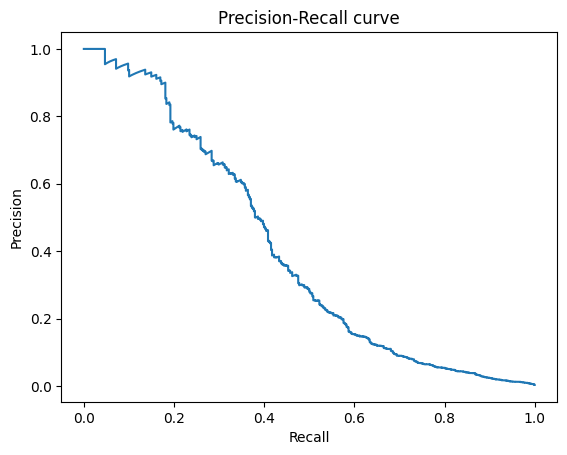

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_logit_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

## Thresholds grid

In [ ]:
grid_df = thresholds_grid(y_logit_pred_proba, y_test)
max_f1 = grid_df[grid_df["f1"] == grid_df["f1"].max()]
max_f05 = grid_df[grid_df["f0.5"] == grid_df["f0.5"].max()]
max_f2 = grid_df[grid_df["f2"] == grid_df["f2"].max()]
grid_df

,thr,precision,recall,f1,f0.5,f2,TP,FP,FN,TN
0,0.000,0.003227,1.000000,0.006432,0.004030,0.015927,448,138399,0,0
1,0.001,0.009674,0.977679,0.019159,0.012063,0.046530,438,44836,10,93563
2,0.002,0.015486,0.939732,0.030470,0.019278,0.072641,421,26765,27,111634
3,0.003,0.021253,0.910714,0.041537,0.026413,0.097194,408,18789,40,119610
4,0.004,0.027411,0.886161,0.053178,0.034001,0.121966,397,14086,51,124313
...,...,...,...,...,...,...,...,...,...,...
417,0.983,1.000000,0.011161,0.022075,0.053419,0.013912,5,0,443,138399
418,0.992,1.000000,0.011161,0.022075,0.053419,0.013912,5,0,443,138399
419,0.994,1.000000,0.006696,0.013304,0.032609,0.008357,3,0,445,138399
420,0.995,1.000000,0.004464,0.008889,0.021930,0.005574,2,0,446,138399


## Precision-recall curve with marked thresholds

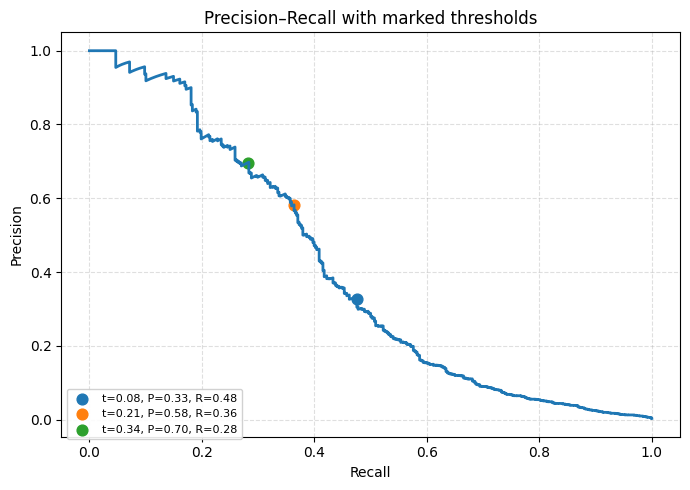

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(recall, precision, lw=2)

mark_thrs = [max_f2.thr.values[0], max_f1.thr.values[0], max_f05.thr.values[0]]

points = pr_at_thresholds(mark_thrs, thresholds, precision, recall)

handles = []
for t, p, r, i in points:
    plt.scatter(r, p, s=60, label=f"t={t:.2f}, P={p:.2f}, R={r:.2f}")
plt.legend(fontsize=8, loc="lower left")

ax.legend(
    fontsize=8, loc="lower left", bbox_to_anchor=(0, -0.02), ncol=1, framealpha=0.9
)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall with marked thresholds")
ax.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

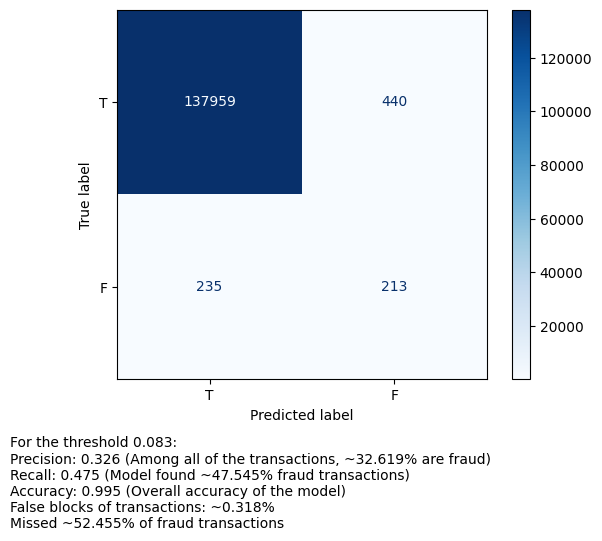

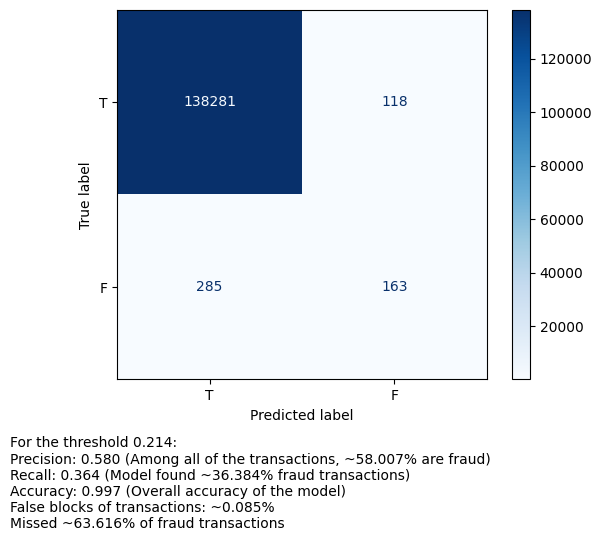

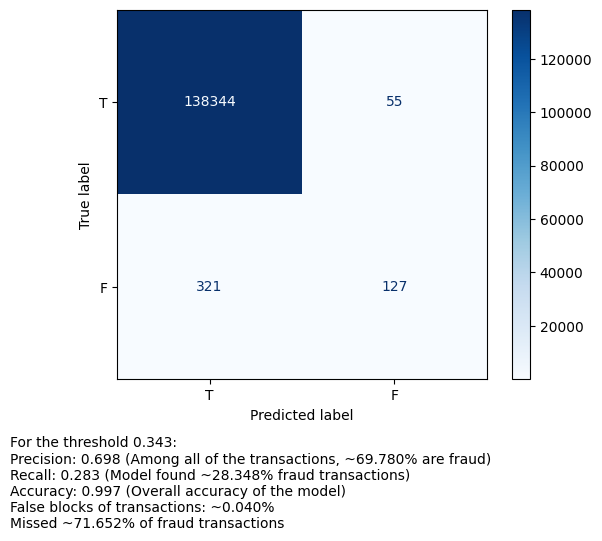

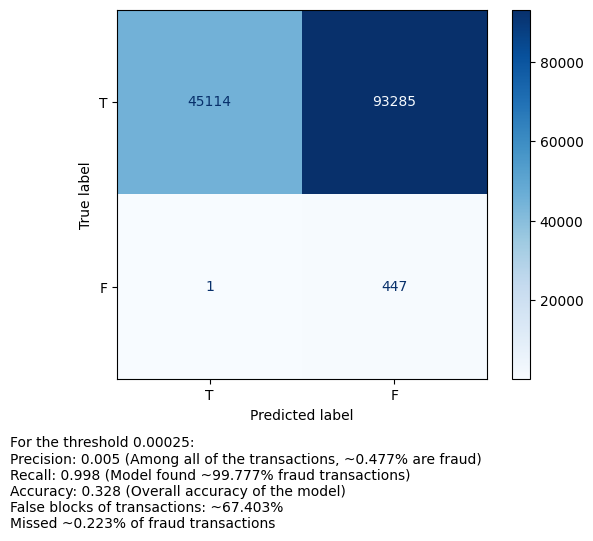

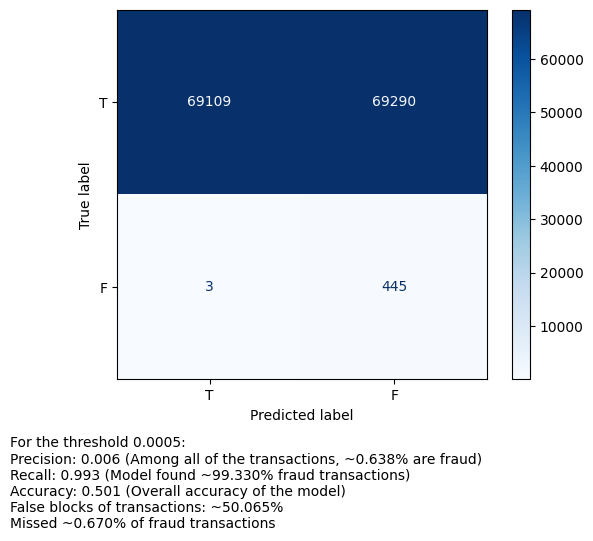

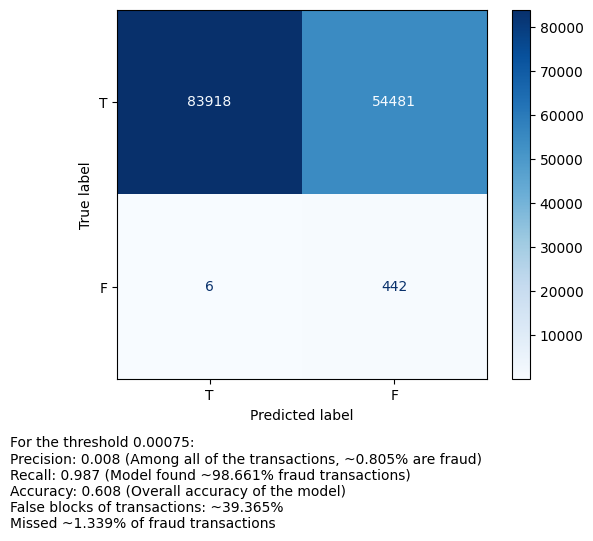

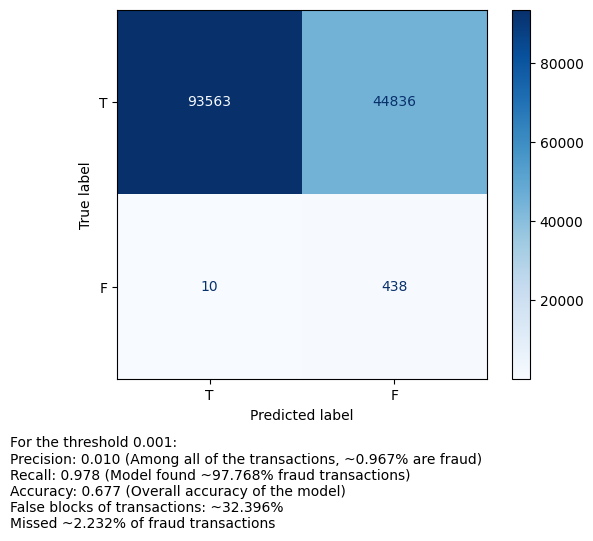

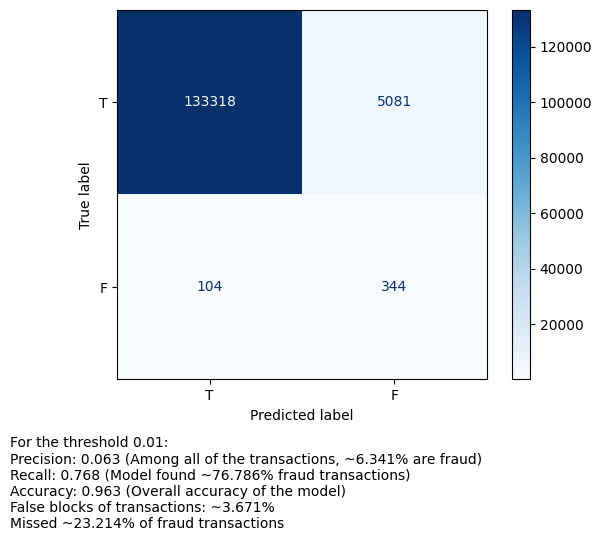

In [ ]:
for thr in mark_thrs + [0.00025, 0.0005, 0.00075, 0.001, 0.01]:
    conf_matrix = cm_for_threshold(thr, y_logit_pred_proba, y_test)
    metrics = explain_confusion_matrix(conf_matrix, thr)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=["T", "F"]
    )
    disp.plot(cmap="Blues")
    disp.figure_.text(0, -0.2, "\n".join(metrics))

## Observations

* Best model result is achived with threshold = `0.001`

## Feature importance

<Figure size 800x600 with 0 Axes>

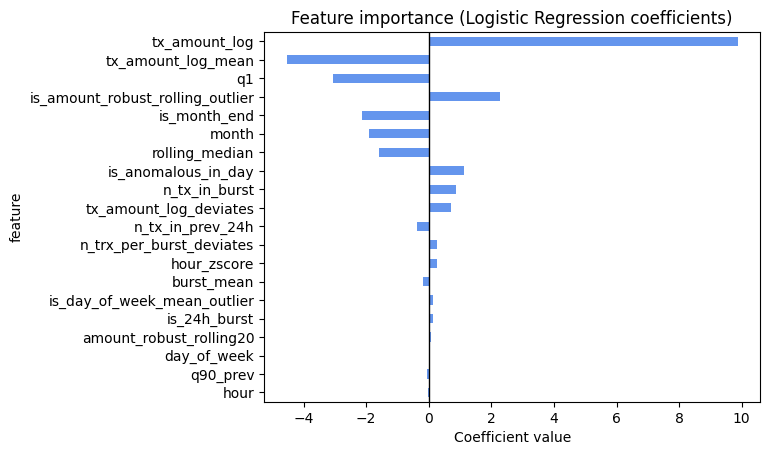

In [ ]:
coef = logit.coef_.ravel()
importance = pd.DataFrame(
    {"feature": FEATURES, "coef": coef, "abs_coef": np.abs(coef)}
).sort_values("abs_coef", ascending=False)

top_n = 20
plt.figure(figsize=(8, 6))
importance.sort_values("abs_coef", ascending=True).tail(top_n).plot(
    kind="barh", x="feature", y="coef", color="cornflowerblue", legend=False
)
plt.title("Feature importance (Logistic Regression coefficients)")
plt.xlabel("Coefficient value")
plt.axvline(0, color="black", lw=1)
plt.show()

## Save model

In [ ]:
joblib.dump(logit, os.path.join(DATA, f"models/logistic_regression.pkl"))

['/Users/vadim.sokoltsov/learning/fraud_transactions_tech_assignment/data/models/logistic_regression.pkl']

### Save thresholds

In [ ]:
save_model_thresholds(os.path.join(DATA, "models/thresholds.yaml"), {"logistic_regression": 0.001})